In [1]:
import pandas as pd
import numpy as np
import mysql.connector
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df=pd.read_csv('medical_insurance.csv')

In [3]:
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="" 
)
cursor = conn.cursor()

In [4]:
cursor.execute("CREATE DATABASE IF NOT EXISTS medical_cost")
print("MySQL database 'medical_cost' created successfully!")
cursor.execute("use food_data")

MySQL database 'medical_cost' created successfully!


In [5]:
cursor.execute("CREATE TABLE IF NOT EXISTS medical_data (id INT AUTO_INCREMENT PRIMARY KEY, age INT," \
"sex VARCHAR(10), bmi FLOAT, children INT, smoker VARCHAR(10), region VARCHAR(50), charges FLOAT)")
conn.commit()

In [6]:
for index, row in df.iterrows():
    cursor.execute(
        "INSERT INTO medical_data (age, sex, bmi, children, smoker, region, charges) VALUES (%s, %s, %s, %s, %s, %s, %s)",
        (row['age'], row['sex'], row['bmi'], row['children'], row['smoker'], row['region'], row['charges'])
    )
conn.commit()

In [7]:

df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [8]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
df.duplicated().sum()


np.int64(1435)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
le_sex = LabelEncoder()
df['sex_encoded'] = le_sex.fit_transform(df['sex'])
print(f"Sex mapping: {list(le_sex.classes_)} -> {list(range(len(le_sex.classes_)))}")

Sex mapping: ['female', 'male'] -> [0, 1]


In [12]:
le_smoker = LabelEncoder()
df['smoker_encoded'] = le_smoker.fit_transform(df['smoker'])
print(f"Smoker mapping: {list(le_smoker.classes_)} -> {list(range(len(le_smoker.classes_)))}")

Smoker mapping: ['no', 'yes'] -> [0, 1]


In [13]:
df= pd.get_dummies(df, columns=['region'], prefix='region', drop_first=True)

In [14]:
print(df.head())

   age     sex     bmi  children smoker      charges  sex_encoded  \
0   19  female  27.900         0    yes  16884.92400            0   
1   18    male  33.770         1     no   1725.55230            1   
2   28    male  33.000         3     no   4449.46200            1   
3   33    male  22.705         0     no  21984.47061            1   
4   32    male  28.880         0     no   3866.85520            1   

   smoker_encoded  region_northwest  region_southeast  region_southwest  
0               1             False             False              True  
1               0             False              True             False  
2               0             False              True             False  
3               0              True             False             False  
4               0              True             False             False  


# a. BMI Classification
# Standard WHO BMI classifications:
# < 18.5: Underweight
# 18.5 - 24.9: Normal weight
# 25.0 - 29.9: Overweight
# >= 30.0: Obesity

In [15]:
bins_bmi = [0, 18.5, 24.9, 29.9, np.inf]
labels_bmi = ['Underweight', 'Normal', 'Overweight', 'Obesity']
df['bmi_category'] = pd.cut(df['bmi'], bins=bins_bmi, labels=labels_bmi, right=True)
print("\nBMI Category counts:")
print(df['bmi_category'].value_counts())



BMI Category counts:
bmi_category
Obesity        715
Overweight     380
Normal         221
Underweight     21
Name: count, dtype: int64


In [16]:
# b. Interaction Terms (Example: Smoker-BMI interaction)
# This can be useful if the effect of BMI on charges is different for smokers vs non-smokers.

In [17]:
df['smoker_bmi_interaction'] = df['smoker_encoded'] * df['bmi']

In [18]:
# c. Age-Smoker Interaction (Example)
df['age_smoker_interaction'] = df['age'] * df['smoker_encoded']

# d. Age-Children Interaction (Example)
df['age_children_interaction'] = df['age'] * df['children']


In [19]:
df.head()

,age,sex,bmi,children,smoker,charges,sex_encoded,smoker_encoded,region_northwest,region_southeast,region_southwest,bmi_category,smoker_bmi_interaction,age_smoker_interaction,age_children_interaction
0,19,female,27.900,0,yes,16884.92400,0,1,False,False,True,Overweight,27.9,19,0
1,18,male,33.770,1,no,1725.55230,1,0,False,True,False,Obesity,0.0,0,18
2,28,male,33.000,3,no,4449.46200,1,0,False,True,False,Obesity,0.0,0,84
3,33,male,22.705,0,no,21984.47061,1,0,True,False,False,Normal,0.0,0,0
4,32,male,28.880,0,no,3866.85520,1,0,True,False,False,Overweight,0.0,0,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       1337 non-null   int64   
 1   sex                       1337 non-null   object  
 2   bmi                       1337 non-null   float64 
 3   children                  1337 non-null   int64   
 4   smoker                    1337 non-null   object  
 5   charges                   1337 non-null   float64 
 6   sex_encoded               1337 non-null   int64   
 7   smoker_encoded            1337 non-null   int64   
 8   region_northwest          1337 non-null   bool    
 9   region_southeast          1337 non-null   bool    
 10  region_southwest          1337 non-null   bool    
 11  bmi_category              1337 non-null   category
 12  smoker_bmi_interaction    1337 non-null   float64 
 13  age_smoker_interaction    1337 non-null   int64   
 1

In [21]:
df.columns.tolist()

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'charges',
 'sex_encoded',
 'smoker_encoded',
 'region_northwest',
 'region_southeast',
 'region_southwest',
 'bmi_category',
 'smoker_bmi_interaction',
 'age_smoker_interaction',
 'age_children_interaction']

2. Medical Insurance Cost Prediction

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Frequency')

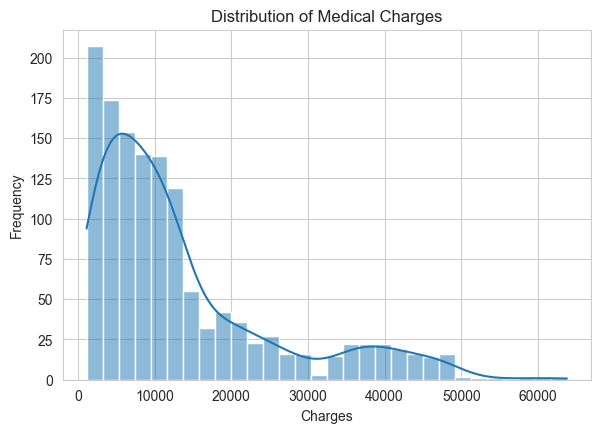

In [23]:
# Set aesthetic style for plots
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# 1. Distribution of Charges
plt.subplot(2, 2, 1)
sns.histplot(df['charges'], kde=True, bins=30)
plt.title('Distribution of Medical Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')

# Observation: Charges are heavily right-skewed. This is common and might suggest a log transformation for linear models, but tree-based models handle it well.

Text(0, 0.5, 'Charges')

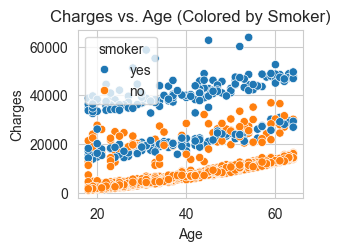

In [24]:
# 2. Charges vs. Age
plt.subplot(2, 2, 2)
sns.scatterplot(x='age', y='charges', data=df, hue='smoker')
plt.title('Charges vs. Age (Colored by Smoker)')
plt.xlabel('Age')
plt.ylabel('Charges')

# Observation: Clear positive correlation between age and charges. Smokers consistently have much higher charges.

Text(0, 0.5, 'Charges')

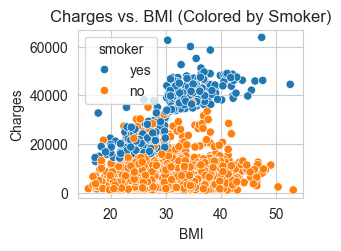

In [25]:
# 3. Charges vs. BMI (Colored by Smoker)
plt.subplot(2, 2, 3)
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')
plt.title('Charges vs. BMI (Colored by Smoker)')
plt.xlabel('BMI')
plt.ylabel('Charges')

# Observation: Charges increase with BMI, especially for smokers. High BMI and smoking are a very expensive combination.

Text(0, 0.5, 'Charges')

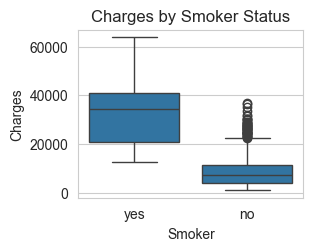

In [26]:
# 4. Charges by Smoker Status
plt.subplot(2, 2, 4)
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by Smoker Status')
plt.xlabel('Smoker')
plt.ylabel('Charges')

# Observation: This is the most significant factor. Smokers pay substantially more.

In [27]:
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))

<Figure size 640x480 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

Text(0, 0.5, 'Charges')

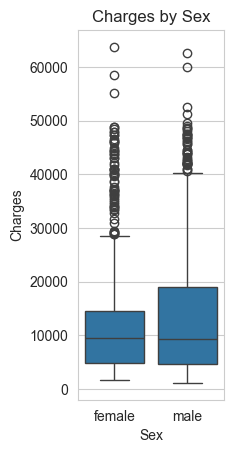

In [28]:
# 5. Charges by Sex
plt.subplot(1, 3, 1)
sns.boxplot(x='sex', y='charges', data=df)
plt.title('Charges by Sex')
plt.xlabel('Sex')
plt.ylabel('Charges')

# Observation: Minor difference, males slightly higher on average.

Text(0, 0.5, 'Charges')

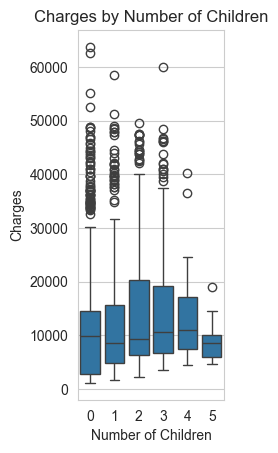

In [29]:
# 6. Charges by Children
plt.subplot(1, 3, 2)
sns.boxplot(x='children', y='charges', data=df)
plt.title('Charges by Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Charges')

# Observation: No very strong trend with children count, but some variations.

Text(0, 0.5, 'Charges')

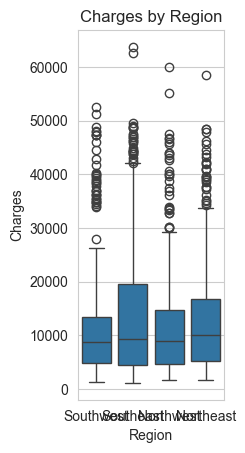

In [30]:
# 7. Charges by Region
plt.subplot(1, 3, 3)

# Reconstruct 'region' column from one-hot encoded columns
df_temp = df[['charges', 'region_northwest', 'region_southeast', 'region_southwest']].copy()
df_temp['region'] = 'Northeast'  # Default if all others are False
df_temp.loc[df_temp['region_northwest'], 'region'] = 'Northwest'
df_temp.loc[df_temp['region_southeast'], 'region'] = 'Southeast'
df_temp.loc[df_temp['region_southwest'], 'region'] = 'Southwest'

sns.boxplot(x='region', y='charges', data=df_temp)
plt.title('Charges by Region')
plt.xlabel('Region')
plt.ylabel('Charges')

In [31]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [32]:
print("\n--- EDA Insights ---")
print("- Charges distribution is heavily right-skewed, indicating many low charges and fewer very high charges.")
print("- 'Smoker' status is the most dominant factor, with smokers incurring significantly higher charges.")
print("- 'Age' shows a strong positive correlation with charges, regardless of smoker status.")
print("- 'BMI' also correlates positively with charges, especially for smokers.")
print("- 'Sex', 'children', and 'region' show relatively weaker impacts on charges compared to 'smoker', 'age', and 'bmi'.")
print("- There might be some regional differences, with the Southeast appearing to have slightly higher median charges.")


--- EDA Insights ---
- Charges distribution is heavily right-skewed, indicating many low charges and fewer very high charges.
- 'Smoker' status is the most dominant factor, with smokers incurring significantly higher charges.
- 'Age' shows a strong positive correlation with charges, regardless of smoker status.
- 'BMI' also correlates positively with charges, especially for smokers.
- 'Sex', 'children', and 'region' show relatively weaker impacts on charges compared to 'smoker', 'age', and 'bmi'.
- There might be some regional differences, with the Southeast appearing to have slightly higher median charges.


# Part 2 and 3: Model Training and Evaluation

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MLflow imports
import mlflow
import mlflow.sklearn
import mlflow.xgboost # For logging XGBoost models specifically

In [34]:
print("\n--- Starting Model Training and Evaluation ---")

# Drop original categorical columns and 'bmi_category' (which is derived) for modeling,
# as we're using their encoded/engineered versions.
# Keep only numeric features and encoded categorical features.
# 'region_northeast' is dropped by get_dummies(drop_first=True), so we don't need to drop it here.
# 'sex' and 'smoker' originals need to be dropped as 'sex_encoded' and 'smoker_encoded' are used.
features_to_drop = ['sex', 'smoker', 'region', 'bmi_category'] # 'region' is dropped by get_dummies, but explicit drop is safer if not.
# Ensure all columns exist before dropping to prevent errors.
features_to_drop = [col for col in features_to_drop if col in df.columns]


--- Starting Model Training and Evaluation ---


In [35]:
X = df.drop(columns=['charges'] + features_to_drop)
y = df['charges']

In [36]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Features used for training: {X_train.columns.tolist()}")



Training data shape: (1069, 11)
Testing data shape: (268, 11)
Features used for training: ['age', 'bmi', 'children', 'sex_encoded', 'smoker_encoded', 'region_northwest', 'region_southeast', 'region_southwest', 'smoker_bmi_interaction', 'age_smoker_interaction', 'age_children_interaction']


In [37]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42, n_jobs=-1), # n_jobs=-1 uses all available cores
    "Support Vector Regressor (SVR)": SVR(kernel='rbf'), # SVR can be computationally expensive and sensitive to scaling
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

# Dictionary to store results
results = {}

In [38]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "MAE": mae, "R-squared": r2}

    print(f"{name} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R-squared: {r2:.4f}")


--- Training Linear Regression ---
Linear Regression Performance:
  RMSE: 4578.13
  MAE: 2831.77
  R-squared: 0.8859

--- Training Random Forest Regressor ---
Random Forest Regressor Performance:
  RMSE: 4776.74
  MAE: 2680.62
  R-squared: 0.8758

--- Training XGBoost Regressor ---
XGBoost Regressor Performance:
  RMSE: 5187.78
  MAE: 2936.54
  R-squared: 0.8535

--- Training Support Vector Regressor (SVR) ---
Support Vector Regressor (SVR) Performance:
  RMSE: 14393.46
  MAE: 9255.69
  R-squared: -0.1274

--- Training Gradient Boosting Regressor ---
Gradient Boosting Regressor Performance:
  RMSE: 4331.74
  MAE: 2521.41
  R-squared: 0.8979


In [39]:
# Display all results in a summary table
print("\n--- Model Performance Summary ---")
results_df = pd.DataFrame(results).T # Transpose to have models as rows
print(results_df.sort_values(by="R-squared", ascending=False))


--- Model Performance Summary ---
                                        RMSE          MAE  R-squared
Gradient Boosting Regressor      4331.736715  2521.406301   0.897887
Linear Regression                4578.126573  2831.769061   0.885940
Random Forest Regressor          4776.735166  2680.620739   0.875829
XGBoost Regressor                5187.781640  2936.538104   0.853539
Support Vector Regressor (SVR)  14393.461733  9255.688331  -0.127428


In [40]:
print("--- Starting MLflow Integrated Medical Insurance Cost Prediction ---")

# --- MLflow Configuration ---
# Set the MLflow tracking URI (where your MLflow server/logs will be stored)
# For local tracking, you can use a file path (default is ./mlruns)
# If using a remote server, set it here: mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_tracking_uri("file:///tmp/mlruns_insurance") # Using /tmp for a clean local run directory
mlflow.set_experiment("Medical Insurance Cost Prediction v2")

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42, n_jobs=-1),
    "Support Vector Regressor (SVR)": SVR(kernel='rbf'), # Note: SVR highly sensitive to feature scaling!
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

--- Starting MLflow Integrated Medical Insurance Cost Prediction ---


In [41]:
# Dictionary to store results for finding the best model
all_results = {}
best_r2 = -float('inf')
best_model_name = ""
best_run_id = None
model_uri_for_registry = ""


In [42]:
# Train and evaluate each model with MLflow logging
for name, model in models.items():
    print(f"\n--- Training {name} with MLflow ---")
    with mlflow.start_run(run_name=name) as run:
        run_id = run.info.run_id
        print(f"MLflow Run ID: {run_id}")

        # Log hyperparameters
        mlflow.log_params(model.get_params())
        print("Logged Model Parameters.")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)



--- Training Linear Regression with MLflow ---
MLflow Run ID: e7f9774971c34bdca8e4cafb4de9e838
Logged Model Parameters.

--- Training Random Forest Regressor with MLflow ---
MLflow Run ID: 0401d1963e74494fa0098dd08623be5e
Logged Model Parameters.

--- Training XGBoost Regressor with MLflow ---
MLflow Run ID: a9576b8a81e949d8840ab1031dd77c6c
Logged Model Parameters.

--- Training Support Vector Regressor (SVR) with MLflow ---
MLflow Run ID: 84effad3c4684cfc9ed49bf198f02370
Logged Model Parameters.

--- Training Gradient Boosting Regressor with MLflow ---
MLflow Run ID: 50d2b464d11442f2ba3f569d184ec6b6
Logged Model Parameters.


In [43]:
# Log metrics
mlflow.log_metrics({
    "rmse": rmse,
    "mae": mae,
    "r2_score": r2
})
print(f"Logged Metrics: RMSE={rmse:.2f}, MAE={mae:.2f}, R-squared={r2:.4f}")


Logged Metrics: RMSE=4331.74, MAE=2521.41, R-squared=0.8979


In [44]:
# Log the trained model as an artifact
if isinstance(model, XGBRegressor):
    mlflow.xgboost.log_model(model, "model", registered_model_name=None) # Don't register directly in loop
else:
    mlflow.sklearn.log_model(model, "model", registered_model_name=None) # Don't register directly in loop
    print(f"Logged {name} model artifact.")

2025/10/04 15:58:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 15:58:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged Gradient Boosting Regressor model artifact.


In [45]:
# Store results for later comparison and best model selection
all_results[name] = {"RMSE": rmse, "MAE": mae, "R-squared": r2, "run_id": run_id}


In [46]:
 # Check for the best performing model based on R-squared
if r2 > best_r2:
    best_r2 = r2
    best_model_name = name
    best_run_id = run_id
# This URI points to the artifact location of the best model in this run
if isinstance(model, XGBRegressor):
    model_uri_for_registry = f"runs:/{run_id}/model"
else:
    model_uri_for_registry = f"runs:/{run_id}/model"

In [47]:
# Display all results in a summary table
print("\n--- Model Performance Summary (from individual MLflow runs) ---")
results_df = pd.DataFrame(all_results).T
print(results_df.sort_values(by="R-squared", ascending=False))

print(f"\nBest performing model: {best_model_name} with R-squared: {best_r2:.4f} (Run ID: {best_run_id})")



--- Model Performance Summary (from individual MLflow runs) ---
                                    RMSE          MAE R-squared  \
Gradient Boosting Regressor  4331.736715  2521.406301  0.897887   

                                                       run_id  
Gradient Boosting Regressor  50d2b464d11442f2ba3f569d184ec6b6  

Best performing model: Gradient Boosting Regressor with R-squared: 0.8979 (Run ID: 50d2b464d11442f2ba3f569d184ec6b6)


In [48]:
# --- Register the best performing model in MLflow’s Model Registry ---
if best_model_name:
    model_name_for_registry = "MedicalInsuranceCostPredictor"
    print(f"\n--- Registering the best model ('{best_model_name}') to MLflow Model Registry ---")
    try:
        # Register the model using its URI from the previous run
        registered_model = mlflow.register_model(
            model_uri=model_uri_for_registry,
            name=model_name_for_registry
        )
        print(f"Model '{best_model_name}' (Version {registered_model.version}) registered as '{model_name_for_registry}'.")
        print(f"MLflow Model Registry URL: mlflow ui --backend-store-uri {mlflow.get_tracking_uri()}")
    except Exception as e:
        print(f"Error registering model: {e}")
        print("Model registry might require a database backend for MLflow, e.g., 'mlflow server --backend-store-uri sqlite:///mlruns.db --default-artifact-root ./mlartifacts'")



--- Registering the best model ('Gradient Boosting Regressor') to MLflow Model Registry ---


Registered model 'MedicalInsuranceCostPredictor' already exists. Creating a new version of this model...


Error registering model: Unable to find a logged_model with artifact_path model under run 50d2b464d11442f2ba3f569d184ec6b6
Model registry might require a database backend for MLflow, e.g., 'mlflow server --backend-store-uri sqlite:///mlruns.db --default-artifact-root ./mlartifacts'


In [49]:
print("\n--- MLflow Integration Complete ---")
print(f"To view the MLflow UI, navigate to the directory where you ran this script and run the command:")
print(f"mlflow ui --backend-store-uri {mlflow.get_tracking_uri()}")
print(f"Or just 'mlflow ui' if using default local backend.")


--- MLflow Integration Complete ---
To view the MLflow UI, navigate to the directory where you ran this script and run the command:
mlflow ui --backend-store-uri file:///tmp/mlruns_insurance
Or just 'mlflow ui' if using default local backend.
